<a href="https://colab.research.google.com/github/ZahraBarati99/Geometry-of-Learning/blob/main/CMD4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score
from scipy.optimize import minimize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# بخش اول: تحلیل های ریاضی (سطوح بدحالت)

## تابع هزینه مصنوعی

In [3]:
# Hessian matrix (Ill−conditioned)
H = np.array([[1.0, 0.0 ], [0.0, 50.0]])

# Quadratic cost function
def cost_func(v):
    return 0.5 * v.T @ H @ v

# Gradient
def gradient(v):
    return H @ v

## مرحله ۱.۱- پیاده‌سازی دستی

###(GD) روش گرادیان کاهشی استاندارد

In [4]:
def gradient_descent(v, alpha=0.03, num_iters=10):

    path = [v]
    costs = [cost_func(v)]

    for i in range(num_iters):
        v = v - alpha * gradient(v)
        path.append(v)
        costs.append(cost_func(v))

    return np.array(path), np.array(costs)

In [5]:
theta = np.array([4.0, 4.0])
path_GD, costs_GD = gradient_descent(theta, alpha=0.03, num_iters=10)

print("Final theta:", path_GD[-1])
print("Final cost:", costs_GD[-1])

Final theta: [2.94969651 0.00390625]
Final cost: 4.3507362131405385


###(Newton) روش نیوتون

In [6]:
def Newton(v, num_iters=10):

    path = [v]
    costs = [cost_func(v)]

    for i in range(num_iters):
        g = gradient(v)
        H_inv = np.linalg.inv(H)
        v = v - H_inv @ g
        path.append(v)
        costs.append(cost_func(v))

    return np.array(path), np.array(costs)

In [7]:
path_Newton, costs_Newton = Newton(theta, num_iters=10)

print("Final theta:", path_Newton[-1])
print("Final cost:", costs_Newton[-1])

Final theta: [0. 0.]
Final cost: 0.0


###(CG)  روش گرادیان مزدوج

In [8]:
def CG(v, num_iters=10):

   path = [v]
   costs = [cost_func(v)]
   r = -gradient(v)
   p = r

   for i in range(num_iters):
       alpha = (r.T @ r) / (p.T @ H @ p)
       v = v + alpha * p
       r_new = r - alpha * (H @ p)
       beta = (r_new.T @ r_new) / (r.T @ r)
       p = r_new + beta * p
       r = r_new

       path.append(v)
       costs.append(cost_func(v))

   return np.array(path), np.array(costs)

In [9]:
path_CG, costs_CG = CG(theta, num_iters=10)

print("Final theta:", path_CG[-1])
print("Final cost:", costs_GD[-1])

Final theta: [ 0.00000000e+00 -7.12103987e-17]
Final cost: 4.3507362131405385


## مرحله ۲.۱- مصورسازی مسیر

In [10]:
x_vals = np.linspace(-10, 10, 400)
y_vals = np.linspace(-8, 8, 400)
X, Y = np.meshgrid(x_vals, y_vals)

Z = 0.5 * (H[0, 0] * X**2 + H[1, 1] * Y**2)

### GD

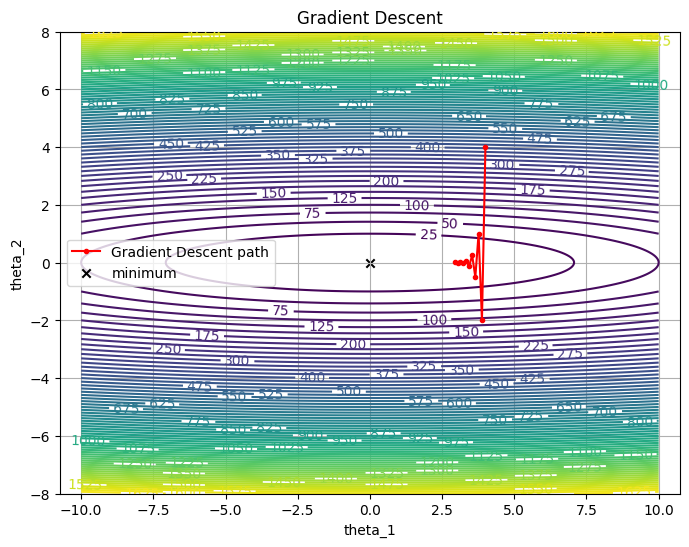

In [11]:
plt.figure(figsize=(8, 6))

contours = plt.contour(X, Y, Z, levels=70)
plt.clabel(contours, inline=True)

plt.plot(path_GD[:,0], path_GD[:,1], '-o', color='red', markersize=3, label='Gradient Descent path')
plt.scatter([0], [0], color='black', marker='x', label='minimum')

plt.title('Gradient Descent')
plt.xlabel('theta_1')
plt.ylabel('theta_2')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

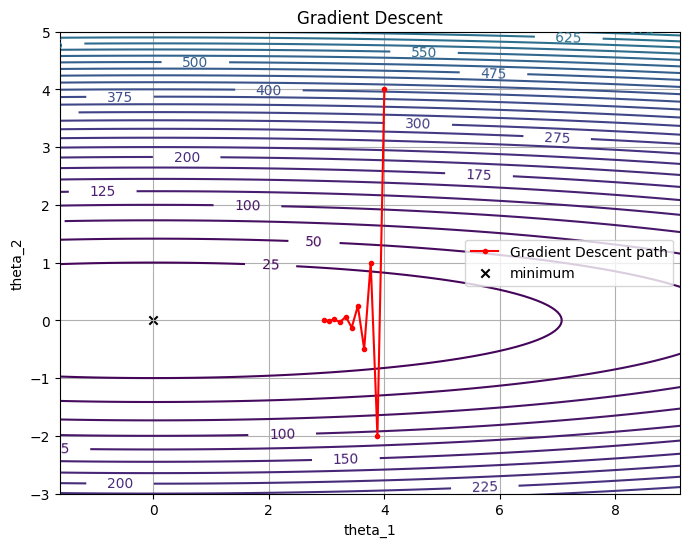

In [12]:
plt.figure(figsize=(8, 6))

contours = plt.contour(X, Y, Z, levels=70)
plt.clabel(contours, inline=True)

plt.plot(path_GD[:,0], path_GD[:,1], '-o', color='red', markersize=3, label='Gradient Descent path')
plt.scatter([0], [0], color='black', marker='x', label='minimum')

plt.title('Gradient Descent')
plt.xlabel('theta_1')
plt.ylabel('theta_2')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.xlim(0.5, 7)
plt.ylim(-3, 5)
plt.show()

### Newton

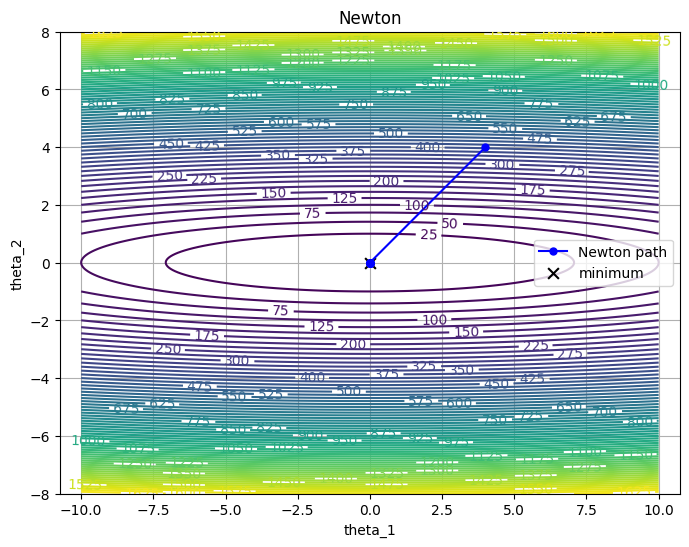

In [13]:
plt.figure(figsize=(8, 6))

contours = plt.contour(X, Y, Z, levels=70)
plt.clabel(contours, inline=True)

plt.plot(path_Newton[:, 0], path_Newton[:, 1],'-o', color='blue', markersize=5, label="Newton path")
plt.scatter([0], [0], color='black', marker='x', s=60, label='minimum')

plt.title('Newton')
plt.xlabel('theta_1')
plt.ylabel('theta_2')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

### CG

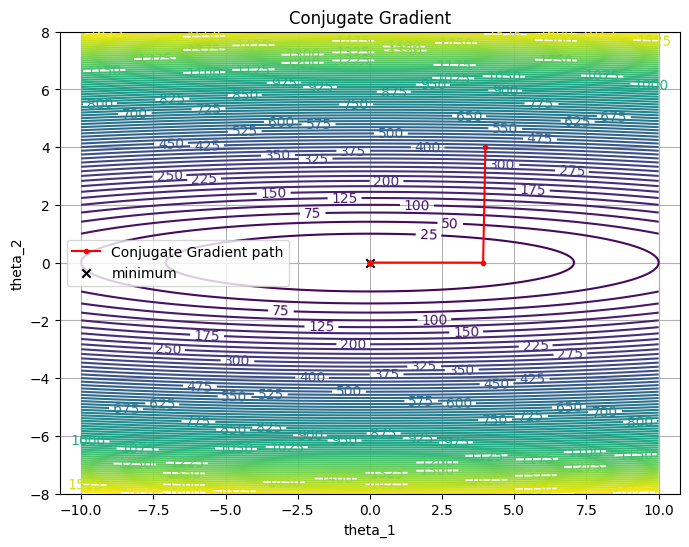

In [14]:
plt.figure(figsize=(8, 6))

contours = plt.contour(X, Y, Z, levels=70)
plt.clabel(contours, inline=True)

plt.plot(path_CG[:,0], path_CG[:,1], '-o', color='red', markersize=3, label='Conjugate Gradient path')
plt.scatter([0], [0], color='black', marker='x', label='minimum')

plt.title('Conjugate Gradient')
plt.xlabel('theta_1')
plt.ylabel('theta_2')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------

# بخش دوم: شبکه عصبی کلاسیک (فضای نیوتونی)

## مرحله ۱.۲- دیتاست و مدل

In [15]:
# Load Breast Cancer dataset

breast_cancer = load_breast_cancer()
df_breast_cancer = pd.DataFrame(breast_cancer['data'], columns=breast_cancer['feature_names'])
df_breast_cancer['target'] = breast_cancer['target']

df_breast_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## مرحله ۲.۲- مسابقه بهینه‌سازها

In [16]:
# Standardize & Train-test split

results = {}

X = breast_cancer.data
y = breast_cancer.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [17]:
# SGD

SGD = MLPClassifier(hidden_layer_sizes=(5,), solver='sgd', learning_rate_init=0.01, max_iter=1000, random_state=42)

start = time.time()
SGD.fit(X_train, y_train)
end = time.time()

y_pred = SGD.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results['SGD'] = {'loss': SGD.loss_curve_, 'time': end-start, 'accuracy': accuracy}
print(f"SGD: Accuracy={accuracy:.4f}, Time={end-start:.2f}s")

SGD: Accuracy=0.9649, Time=0.12s


In [18]:
# LBFGS

LBFGS = MLPClassifier(hidden_layer_sizes=(5,), solver='lbfgs', learning_rate_init=0.01, max_iter=1000, random_state=42)

start = time.time()
LBFGS.fit(X_train, y_train)
end = time.time()

y_pred = LBFGS.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results['LBFGS'] = {'loss': [LBFGS.loss_], 'time': end-start, 'accuracy': accuracy}
print(f"LBFGS: Accuracy={accuracy:.4f}, Time={end-start:.2f}s")

LBFGS: Accuracy=0.9591, Time=0.02s


In [19]:
# CG

n_features = X_train.shape[1]
hidden_dim = 5
output_dim = 1

In [20]:
def unpack_theta(theta):

    idx = 0
    W1_size = n_features * hidden_dim
    W1 = theta[idx:idx + W1_size].reshape(n_features, hidden_dim)
    idx += W1_size

    b1 = theta[idx:idx + hidden_dim]
    idx += hidden_dim

    W2_size = hidden_dim * output_dim
    W2 = theta[idx:idx + W2_size].reshape(hidden_dim, output_dim)
    idx += W2_size

    b2 = theta[idx:idx + output_dim]
    return W1, b1, W2, b2

In [21]:
def forward(X, theta):

    W1, b1, W2, b2 = unpack_theta(theta)
    Z1 = X @ W1 + b1
    A1 = np.tanh(Z1)
    Z2 = A1 @ W2 + b2
    probs = 1.0 / (1.0 + np.exp(-Z2.ravel()))
    return A1, probs

In [22]:
def loss_and_grad(theta, X, y):

    N = X.shape[0]
    y = y.astype(float)

    W1, b1, W2, b2 = unpack_theta(theta)

    Z1 = X @ W1 + b1
    A1 = np.tanh(Z1)
    Z2 = A1 @ W2 + b2
    logits = Z2.ravel()
    probs = 1.0 / (1.0 + np.exp(-logits))

    eps = 1e-12
    loss = -np.mean(y * np.log(probs + eps) + (1 - y) * np.log(1 - probs + eps))

    dlogits = (probs - y) / N

    dW2 = A1.T @ dlogits.reshape(-1, 1)
    db2 = np.sum(dlogits)

    dA1 = dlogits.reshape(-1, 1) @ W2.T
    dZ1 = dA1 * (1 - A1**2)

    dW1 = X.T @ dZ1
    db1 = np.sum(dZ1, axis=0)

    grad = np.concatenate([dW1.ravel(), db1.ravel(), dW2.ravel(), np.array([db2])])

    return loss, grad

In [23]:
rng = np.random.default_rng(42)
theta0 = rng.normal(loc=0.0, scale=0.1, size=n_features*hidden_dim + hidden_dim + hidden_dim*output_dim + output_dim)

In [24]:
loss_history_CG = []

def callback_CG(theta):

    loss, _ = loss_and_grad(theta, X_train, y_train)
    loss_history_CG.append(loss)

start = time.time()

res = minimize(fun=lambda th: loss_and_grad(th, X_train, y_train), x0=theta0, method='CG', jac=True, callback=callback_CG, options={'maxiter': 1000, 'gtol': 1e-4})

end = time.time()
theta_opt = res.x

_, probs_test = forward(X_test, theta_opt)
y_pred_CG = (probs_test >= 0.5).astype(int)
accuracy_CG = accuracy_score(y_test, y_pred_CG)

results['CG'] = {'loss': loss_history_CG, 'time': end - start, 'accuracy': accuracy_CG}

print(f"CG:  Accuracy={accuracy_CG:.4f}, Time={end-start:.2f}s, Iterations={len(loss_history_CG)}")

CG:  Accuracy=0.9532, Time=0.08s, Iterations=58


## مرحله ۳.۲- نمودار مقایسه‌ای

In [25]:
def build_time_axis(total_time, loss_list):

    n = len(loss_list)
    if n == 1:
        return np.array([total_time])

    return np.linspace(0, total_time, n)

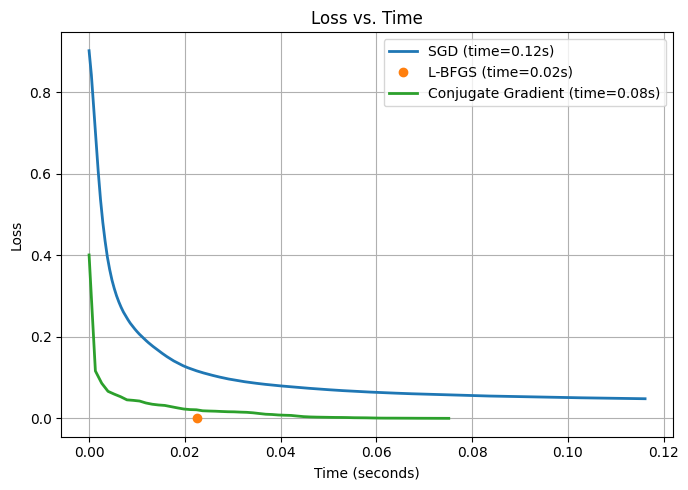

In [26]:
loss_SGD   = results['SGD']['loss']
time_SGD   = results['SGD']['time']
loss_LBFGS = results['LBFGS']['loss']
time_LBFGS = results['LBFGS']['time']
loss_CG    = results['CG']['loss']
time_CG    = results['CG']['time']

t_SGD   = build_time_axis(time_SGD,   loss_SGD)
t_LBFGS = build_time_axis(time_LBFGS, loss_LBFGS)
t_CG    = build_time_axis(time_CG,    loss_CG)

plt.figure(figsize=(7, 5))

plt.plot(t_SGD, loss_SGD, label=f"SGD (time={time_SGD:.2f}s)", linewidth=2)

plt.plot(t_LBFGS, loss_LBFGS, 'o', label=f"L-BFGS (time={time_LBFGS:.2f}s)")

plt.plot(t_CG, loss_CG, label=f"Conjugate Gradient (time={time_CG:.2f}s)", linewidth=2)

plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Loss vs. Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

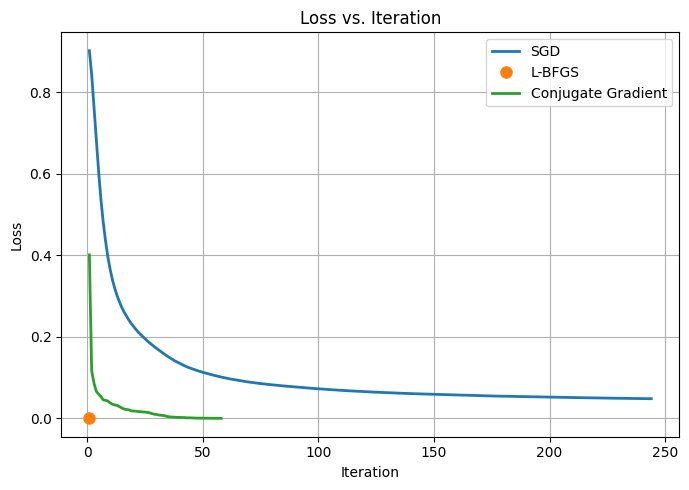

In [27]:
loss_SGD = results['SGD']['loss']
loss_LBFGS = results['LBFGS']['loss']
loss_CG = results['CG']['loss']


iters_SGD = np.arange(1, len(loss_SGD) + 1)
iters_CG = np.arange(1, len(loss_CG) + 1)
iters_LBFGS = np.array([1])  # only one point

plt.figure(figsize=(7, 5))

plt.plot(iters_SGD, loss_SGD, label="SGD", linewidth=2)

plt.plot(iters_LBFGS, loss_LBFGS, 'o', markersize=8, label="L-BFGS")

plt.plot(iters_CG, loss_CG, label="Conjugate Gradient", linewidth=2)

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs. Iteration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------

# بخش سوم: شبکه عمیق و تله ی مقیاس پذیری

## مرحله ۱.۳- مدل عمیق

In [28]:
# Load Fashion-MNIST dataset

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# reshape
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test  = x_test.reshape(-1, 28*28)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
# Build model
num_classes = 10

def build_model():
    model = keras.Sequential([
        layers.Input(shape=(28*28,)),
        layers.Dense(100, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(num_classes, activation="softmax")])
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,710 (389.49 KB)

 Trainable params: 99,710 (389.49 KB)

 Non-trainable params: 0 (0.00 B)

## مرحله ۲.۳-  محاسبه ابعاد هسین

In [30]:
N = model.count_params()
print("Total parameters N:", N)

bytes_per_float = 4
hessian_bytes = N * N * bytes_per_float
hessian_gb = hessian_bytes / (1024**3)
print("Hessian size (N x N) in GB:", hessian_gb)

Total parameters N: 99710
Hessian size (N x N) in GB: 37.03714944422245


## مرحله ۳.۳-  جایگزین ها

In [31]:
def train_with_timing(model, optimizer, x, y, batch_size=128, epochs=5):
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy"
    )

    times = []
    losses = []

    start = time.time()
    for epoch in range(epochs):
        hist = model.fit(x, y, batch_size=batch_size, epochs=epoch+1, initial_epoch=epoch, verbose=0)

        elapsed = time.time() - start
        loss = hist.history["loss"][0]

        times.append(elapsed)
        losses.append(loss)

        print(f"Epoch {epoch+1}/{epochs}  loss={loss:.4f}   time={elapsed:.1f}s")

    return np.array(times), np.array(losses)

In [32]:
model_SGD  = build_model()
times_SGD, losses_SGD = train_with_timing(model_SGD, optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), x=x_train, y=y_train, epochs=15)

model_Adam = build_model()
times_Adam, losses_Adam = train_with_timing(model_Adam, optimizer=keras.optimizers.Adam(learning_rate=0.001), x=x_train, y=y_train, epochs=15)

Epoch 1/15  loss=0.6836   time=2.0s
Epoch 2/15  loss=0.4351   time=3.2s
Epoch 3/15  loss=0.3890   time=4.9s
Epoch 4/15  loss=0.3681   time=6.0s
Epoch 5/15  loss=0.3462   time=7.2s
Epoch 6/15  loss=0.3318   time=8.5s
Epoch 7/15  loss=0.3167   time=9.8s
Epoch 8/15  loss=0.3016   time=11.2s
Epoch 9/15  loss=0.2970   time=12.5s
Epoch 10/15  loss=0.2861   time=13.7s
Epoch 11/15  loss=0.2779   time=15.4s
Epoch 12/15  loss=0.2699   time=16.9s
Epoch 13/15  loss=0.2624   time=18.2s
Epoch 14/15  loss=0.2557   time=19.6s
Epoch 15/15  loss=0.2476   time=20.9s
Epoch 1/15  loss=0.5580   time=2.3s
Epoch 2/15  loss=0.3844   time=3.7s
Epoch 3/15  loss=0.3416   time=5.4s
Epoch 4/15  loss=0.3195   time=7.2s
Epoch 5/15  loss=0.3011   time=8.6s
Epoch 6/15  loss=0.2868   time=10.1s
Epoch 7/15  loss=0.2757   time=11.7s
Epoch 8/15  loss=0.2638   time=13.2s
Epoch 9/15  loss=0.2511   time=14.5s
Epoch 10/15  loss=0.2445   time=15.8s
Epoch 11/15  loss=0.2343   time=18.0s
Epoch 12/15  loss=0.2276   time=19.6s
Epoc

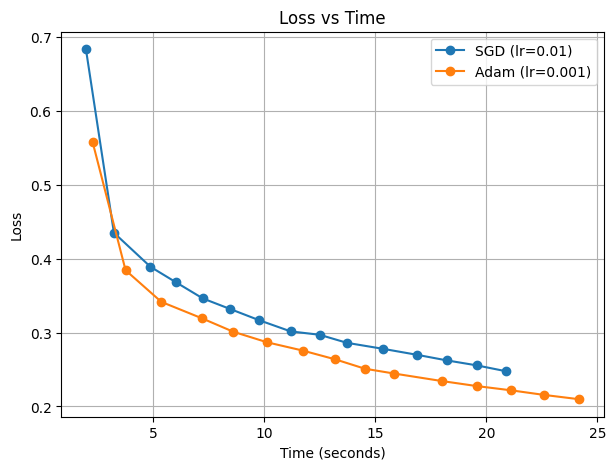

In [33]:
plt.figure(figsize=(7,5))
plt.plot(times_SGD, losses_SGD, marker="o", label="SGD (lr=0.01)")
plt.plot(times_Adam, losses_Adam, marker="o", label="Adam (lr=0.001)")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Loss vs Time")
plt.legend()
plt.grid(True)
plt.show()

# (رویکرد داده‌کاوی) QR بخش چهارم: تعامد و


## مرحله ۱.۴-  آماده‌سازی داده همبسته  

In [34]:
from google.colab import files
uploaded = files.upload()

Saving HousingData.csv to HousingData.csv


In [35]:
# Upload dataset
df_house = pd.read_csv("HousingData.csv")
df_house_full = df_house.copy()

# Replacing non-numeric characters with NaN
df_house_full = df_house_full.replace(['?', 'NA'], np.nan)

# Delete rows with missing values
df_house_full = df_house_full.dropna()

df_house_full.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [36]:
# Separate features and target
X = df_house_full.drop(columns=["MEDV"]).values
y = df_house_full["MEDV"].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (394, 13)
y shape: (394,)


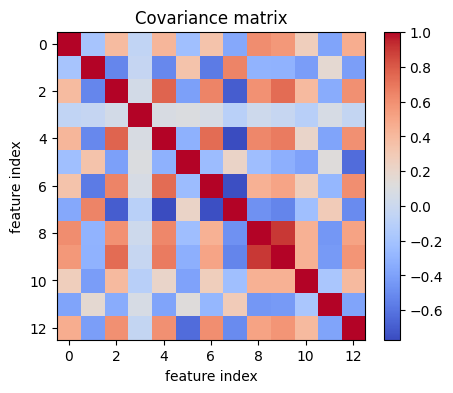

In [37]:
# Visualize covariance matrix of training features

cov = np.cov(X, rowvar=False)

plt.figure(figsize=(5, 4))
im = plt.imshow(cov, cmap="coolwarm")
plt.colorbar(im)
plt.title("Covariance matrix")
plt.xlabel("feature index")
plt.ylabel("feature index")
plt.show()

## QR مرحله ۲.۴- تجزیه   

In [38]:
# QR

Q, R = np.linalg.qr(X, mode="reduced")
print("Q shape:", Q.shape)
print("R shape:", R.shape)

Q shape: (394, 13)
R shape: (13, 13)


##  مرحله ۳.۴- تاثیر بر گرادیان کاهشی   

In [39]:
def SGD_linear(X, y, lr=0.1, epochs=100):

    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0

    losses = []
    times = []

    start = time.time()

    for epoch in range(epochs):
        y_pred = X @ w + b
        error = y_pred - y
        loss = 0.5 * np.mean(error**2)
        losses.append(loss)

        grad_w = X.T @ error / n_samples
        grad_b = np.mean(error)

        w -= lr * grad_w
        b -= lr * grad_b

        elapsed = time.time() - start
        times.append(elapsed)

    return w, b, np.array(losses), np.array(times)

In [40]:
w_X, b_X, losses_X, times_X = SGD_linear(X, y, lr=0.01, epochs=500)
w_Q, b_Q, losses_Q, times_Q = SGD_linear(Q, y, lr=0.01, epochs=500)

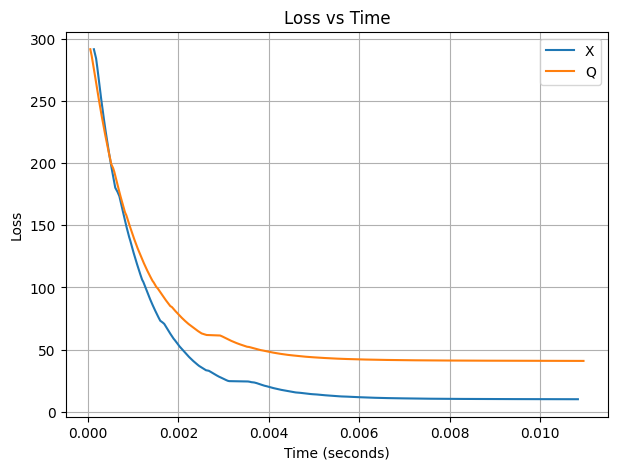

In [41]:
plt.figure(figsize=(7,5))
plt.plot(times_X, losses_X, label="X")
plt.plot(times_Q, losses_Q, label="Q")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Loss vs Time")
plt.legend()
plt.grid(True)
plt.show()